In [7]:
!pip install imutils
!pip install image-classifiers==1.0.0b1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0b1-py3-none-any.whl size=19968 sha256=ec2eb8151b08190efcd37d11ee75039a77d85bf9c7106eac74b96c0bfcd165e4
  Stored in directory: /root/.cache/pip/wheels/59/ee/99/bdd974449ed4653c3c2e37d600817c9da816057dfa43c67878
Successfully built image-classifiers


In [8]:
# import the necessary packages
import tensorflow as tf
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, DenseNet169
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
import keras.applications
from datetime import datetime
%load_ext tensorboard

In [3]:
!pip install --upgrade -q kaggle

!mkdir /root/.kaggle
import json
token = {
    "username": "zahidhussain909",
    "key": "39a06efd89d0f2a699143b8d3d62b216"
}

with open('/root/.kaggle/kaggle.json', 'w') as config_file:
    json.dump(token, config_file)
!chmod 600 /root/.kaggle/kaggle.json


!kaggle datasets download -d zahidhussain909/denoised-oct-balanced

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 1.04G/1.05G [00:08<00:00, 143MB/s]
100% 1.05G/1.05G [00:08<00:00, 138MB/s]


In [4]:
import zipfile
zipref=zipfile.ZipFile("/content/denoised-oct-balanced.zip",'r')
zipref.extractall()
zipref.close()

In [5]:
class_to_label_map = {'covid' : 1, 'normal' : 0}

In [10]:
samples = 500

In [13]:
normal_dataset_path = '/content/DENOISED OCT/train/NORMAL'

In [15]:
dataset_path = '/content/dataset'
log_path = '/content/logs'

!mkdir dataset
!mkdir logs

dataset_path = '/content/dataset'
log_path = '/content/logs'

!mkdir dataset/covid
!mkdir dataset/normal

In [34]:
basePath = normal_dataset_path
imagePaths = list(paths.list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [35]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))

In [36]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 180x180 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (180, 180), interpolation = cv2.INTER_AREA)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(class_to_label_map[label])
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [37]:
# perform one-hot encoding on the labels
# perform one-hot encoding on the labels
#labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15, stratify=labels, random_state=42)
# initialize the training data augmentation object
train_datagen = ImageDataGenerator(
                                   rotation_range=60,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator()

In [38]:
trainYSparse = trainY
trainY = to_categorical(trainY)

In [9]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, 
                     
                self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [23]:
model = create_model()
model.load_weights('/content/classify_model4.h5')

NameError: ignored

In [25]:
model = tf.keras.models.load_model('/content/classify_model4.h5')

In [26]:
np.where(testY == 0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74]),)

In [27]:
covid1 = testX[10]
covid2 = testX[28]
covid3 = testX[29]
covid_list = [covid1, covid2, covid3]
#pneumonia1 = testX[2]
#pneumonia2 = testX[43]
#pneumonia3 = testX[52]
#pneumonia_list = [pneumonia1, pneumonia2, pneumonia3]

In [39]:
image = testX[7]
preds = model.predict(image[np.newaxis,...])
preds

1/1 [==============================] - 7s 7s/step


array([[1.2730581e-08, 2.3029465e-03, 1.9513692e-03, 9.9574572e-01]],
      dtype=float32)

In [40]:

preds = model.predict(image[np.newaxis,...])
i = np.argmax(preds[0])

# decode the ImageNet predictions to obtain the human-readable label

# # initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image[np.newaxis,...])

img_copy = np.copy(image)
img_copy -= img_copy.min((0,1))
img_copy = (255*img_copy).astype(np.uint8)
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, img_copy, alpha=0.5)

1/1 [==============================] - 0s 22ms/step


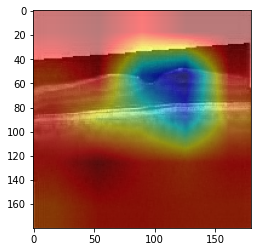

In [41]:
plt.imshow(output, cmap = 'gray')

In [42]:
def plot_map(img_list):
    fig, axes = plt.subplots(len(img_list), 2, figsize=(15, 15))
    fig.suptitle('Covid 19 Grad-CAM\n',fontsize=20)
    
    for i, img in enumerate(img_list):
        preds = model.predict(img[np.newaxis,...])
        axes[i,0].imshow(img, cmap = 'bone')
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
      #  axes[i,0].set_title(f'{class_label[np.argmax(preds[:, 1:]) + 1]} / {class_label[np.argmax(label[:, 1:]) + 1]} / {np.max(preds[:, 1:]):.4f}')
        heatmap = cam.compute_heatmap(img[np.newaxis,...])
        img_copy = np.copy(img)
        img_copy -= img_copy.min((0,1))
        img_copy = (255*img_copy).astype(np.uint8)
        # resize the resulting heatmap to the original input image dimensions
        # and then overlay heatmap on top of the image
        heatmap = cv2.resize(heatmap, (img_copy.shape[1], img_copy.shape[0]))
        (heatmap, output) = cam.overlay_heatmap(heatmap, img_copy, alpha=0.5)
        axes[i,1].imshow(output)
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        #axes[i,1].set_title("heatmap showing hemorrhage location")
    plt.subplots_adjust(wspace=1, hspace=0.2)
    plt.savefig('CovidGradCAM.png')

InvalidArgumentError: ignored

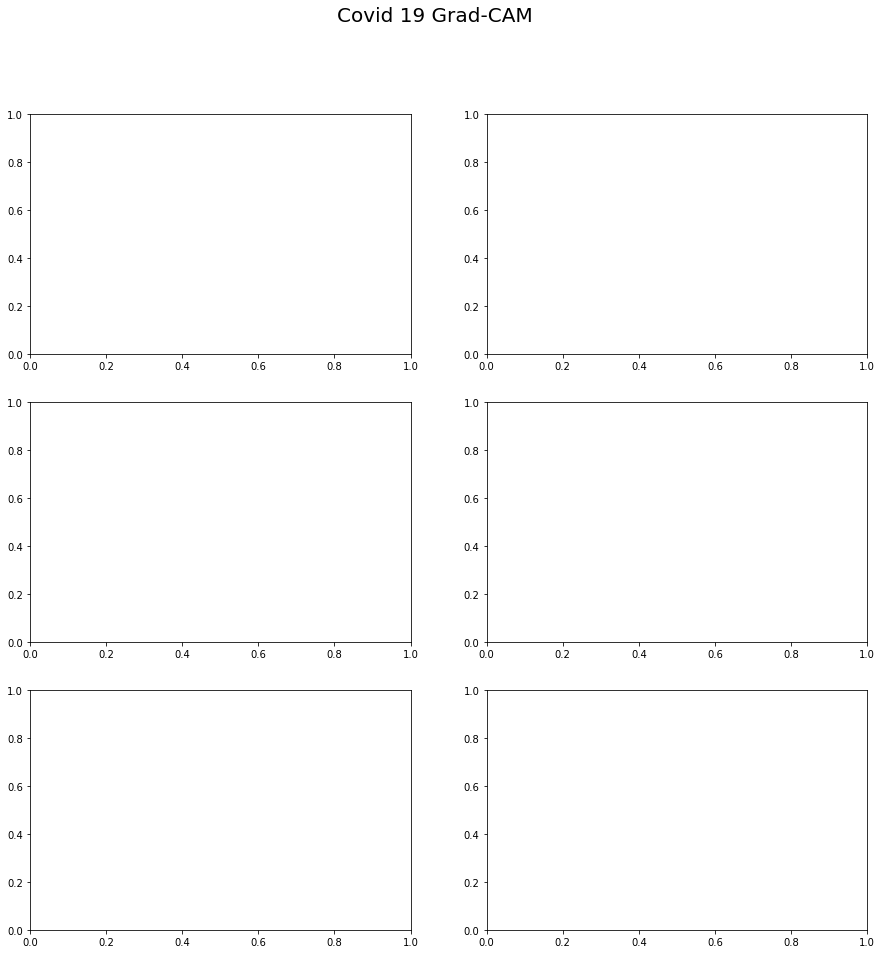

In [43]:
plot_map(covid_list)

In [ ]:
#plot_map(pneumonia_list)

### Evaluation

In [ ]:
predY = np.average(submission_predictions, axis = 0, weights = [2**i for i in range(len(submission_predictions))])

In [ ]:
class_to_label_map = {1 : 'covid', 0 : 'normal'}

In [ ]:
cm_mat = confusion_matrix(testY, np.argmax(predY, axis = -1))

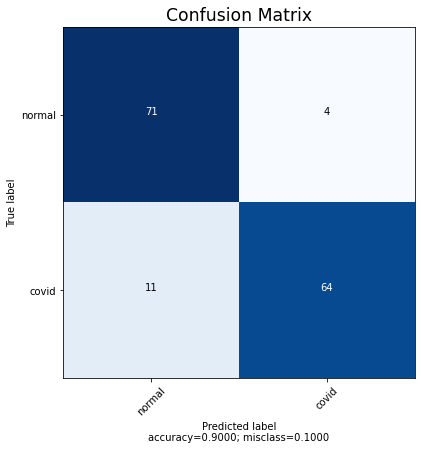

In [ ]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm_mat, 
                      normalize = False,
                      target_names = ['normal', 'covid'],
                      title        = "Confusion Matrix")

In [ ]:
print(classification_report(testY, np.argmax(predY, axis = -1), target_names = ['normal', 'covid']))

              precision    recall  f1-score   support

      normal       0.87      0.95      0.90        75
       covid       0.94      0.85      0.90        75

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150



#### Confusion matrix

In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY, np.argmax(predY, axis = -1))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[71  4]
 [11 64]]
acc: 0.9000
sensitivity: 0.9467
specificity: 0.8533


In [ ]:
!rm -rf dataset
!rm -rf logs